In [80]:
import os
import time
import scipy
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
tfk = tf.keras
tfkl = tf.keras.layers

In [81]:
onColab = True

seed = 20
doUnzipData = False

validation_split = 0.15
batch_size = 256

# IF YOU CHANGE NET GO CHECK THE FINE TUNING CODE IF IT IS ALRIGHT!

model_dir = 'ResNet152V2_best_175_64_denselayerft_test210_weightOnClasses'
net = tfk.applications.ResNet152V2

def tl_preprocess(x):
  return tf.keras.applications.resnet_v2.preprocess_input(x)

class_weight = {0: 0.2559095580678314, 1: 0.5508849557522124, 2: 0.4383802816901408, 3: 0.20906801007556675, 4: 0.17255717255717254, 5: 0.1436814772071552, 6: 0.2588357588357588, 7: 0.33199999999999996, 8: 0.35520684736091296, 9: 0.999999999999999999999, 10: 0.15552779512804496, 11: 0.44543828264758495, 12: 0.378419452887538, 13: 0.043853469531525184}

comment = '''
resnet50, transfer learning, fine tuned with last conv layer trainable. dense layer with drop out 0.5, 175 neurons, another one dropout 0.3 and 64 neurons. test of 210 imgs (first 15 imgs per class). validation_split = 0.15. batch_size = 20. seed = 20.
'''
comment += ' weigths: '
comment += str(class_weight)
print(comment)


resnet50, transfer learning, fine tuned with last conv layer trainable. dense layer with drop out 0.5, 175 neurons, another one dropout 0.3 and 64 neurons. test of 210 imgs (first 15 imgs per class). validation_split = 0.15. batch_size = 20. seed = 20.
 weigths: {0: 0.2559095580678314, 1: 0.5508849557522124, 2: 0.4383802816901408, 3: 0.20906801007556675, 4: 0.17255717255717254, 5: 0.1436814772071552, 6: 0.2588357588357588, 7: 0.33199999999999996, 8: 0.35520684736091296, 9: 1.0, 10: 0.15552779512804496, 11: 0.44543828264758495, 12: 0.378419452887538, 13: 0.043853469531525184}


In [82]:
#@title init seed everywhere
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [83]:
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE1/
  !ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/University/ANN/CHALLENGE1
01-Challenge.ipynb
carpa.ipynb
dataset.zip
inceptionv_3_best
mobilenet_v2_best_trained_on_test
model.png
new_pipeline.ipynb
plotting.ipynb
resnet50_best_128denselayerft_test140_weightOnClasses
resnet50_best_false
resnet_best_200denselayerft
resnetv2_best_trained_on_test_200_denselayerft
test
training
try_img_preproc.ipynb
trySubmission.ipynb


In [84]:
if doUnzipData:
  !unzip dataset.zip
  test_path = "./test"
  dataset_dir = './training'
    #if isTest and not os.path.exists(test_path):
  import shutil
  os.mkdir(test_path)
  for i in range(len(labels)):
      class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
      # In this way we always get the same data. 
      # TODO: randomize using seed the data we take
      class_imgs.sort()
      for j in range(15):
        class_img = class_imgs[j]
        dest_dir = './test/' + labels[i] + '/'
        if not os.path.exists(dest_dir):
          os.mkdir(dest_dir)
        shutil.move('{}/{}/'.format(dataset_dir, labels[i]) + class_img, dest_dir)


In [85]:
def clean_image(x):
  """
  remove background from image
  """
  i = np.uint8(x)
  blurr = cv2.GaussianBlur(i, (5,5),0)
  hsv = cv2.cvtColor(blurr, cv2.COLOR_RGB2HSV)
  #GREEN PARAMETERS
  lower = (25,40,50)
  upper = (75,255,255)
  mask = cv2.inRange(hsv,lower,upper)
  struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
  mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
  boolean = mask > 0
  new = np.zeros_like(i,np.uint8)
  new[boolean] = i[boolean]

  # Uncomment to see plots
  # plt.subplot(2,3,1);plt.imshow(i) # ORIGINAL
  # plt.subplot(2,3,2);plt.imshow(blurr) # BLURRED
  # plt.subplot(2,3,3);plt.imshow(hsv) # HSV CONVERTED
  # plt.subplot(2,3,4);plt.imshow(mask) # MASKED
  # plt.subplot(2,3,5);plt.imshow(boolean) # BOOLEAN MASKED
  # plt.subplot(2,3,6);plt.imshow(new) # NEW PROCESSED IMAGE
  # plt.show()
  return new

In [86]:
def preprocess(x):
  # x = clean_image(x)
  if tl_preprocess:
    return tl_preprocess(np.uint8(x))
  return x

In [87]:
isTest = True
dataset_path = './training'
img_h, img_w = (256, 256)
test_path = './test'

labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

def load_data(dontUseFun=True, fun=None):
  """
  load data (train, val, test)
  dontUseFun: if it's true then the data is not preprocessed. If it's false, the data is preprocessed with fun (which must not be none)
  """
  image_generator = ImageDataGenerator(preprocessing_function = fun, validation_split=validation_split, 
                                          rotation_range=30,
                                          height_shift_range=50,
                                          width_shift_range=50,
                                          zoom_range=0.3,
                                          horizontal_flip=True,
                                          vertical_flip=True, 
                                          fill_mode='reflect')  
  if dontUseFun:
    image_generator = ImageDataGenerator(validation_split=validation_split, 
                                          rotation_range=30,
                                          height_shift_range=50,
                                          width_shift_range=50,
                                          zoom_range=0.3,
                                          horizontal_flip=True,
                                          vertical_flip=True, 
                                          fill_mode='reflect')  


  # Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
  train_gen = image_generator.flow_from_directory(directory=dataset_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=labels, # can be set to None
                                                class_mode='categorical',
                                                subset='training',
                                                batch_size=batch_size,
                                                shuffle=True,
                                                seed=seed)

  valid_gen = image_generator.flow_from_directory(directory=dataset_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=labels, # can be set to None
                                                class_mode='categorical',
                                                subset='validation',
                                                batch_size=batch_size,
                                                shuffle=False,
                                                seed=seed)
  test_gen = None
  if isTest:
    test_image_gen = ImageDataGenerator(preprocessing_function = fun)
    if dontUseFun:
      test_image_gen = ImageDataGenerator(rotation_range=30)
    
    test_gen = test_image_gen.flow_from_directory(directory=test_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=labels, # can be set to None
                                                class_mode='categorical',
                                                batch_size=batch_size,
                                                shuffle=True, # sometimes, instead of train, we use the test for training
                                                seed=seed)
  return train_gen, valid_gen, test_gen

train_gen, valid_gen, test_gen = load_data(False, preprocess)

Found 14898 images belonging to 14 classes.
Found 2620 images belonging to 14 classes.
Found 210 images belonging to 14 classes.


In [88]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(image)
  plt.title("image which will be fed to the cnn")
  return batch

# Get a sample from dataset and show info
# _ = get_next_batch(train_gen)

In [89]:
supernet =  net(
    weights="imagenet",
    input_shape=(img_h, img_w, 3),
    include_top=False
    )

234561536/234545216 [==============================] - 11s 0us/step


In [90]:
print(len(supernet.layers))

564


In [91]:
# let last block trainable
for i, layer in enumerate(supernet.layers[:558]):
  layer.trainable=False
for i, layer in enumerate(supernet.layers):
  print(i, layer.name, layer.trainable)
# supernet.summary()

# Now we use the supernet as layer of our network
inputs = tfk.Input(shape=(img_h, img_w, 3))
x = supernet(inputs)

# Now we build our classifier (which will be actually trained)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    175, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.5, seed=seed)(x)
x = tfkl.Dense(
    64, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    len(labels), 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

model.summary()

0 input_7 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [ ]:
history = model.fit(
    x = train_gen,
    batch_size = batch_size,
    epochs = 200,
    validation_data = valid_gen,
    class_weight = class_weight,
    callbacks = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
).history

Epoch 1/200
15/59 [======>.......................] - ETA: 4:01 - loss: 0.6566 - accuracy: 0.2180

In [53]:
model.save('./' + model_dir)

INFO:tensorflow:Assets written to: ./resnet50_best_128denselayerft_test140_weightOnClasses/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [54]:
model.evaluate(test_gen, return_dict=True)

1/1 [==============================] - 3s 3s/step - loss: 0.3483 - accuracy: 0.9381


{'accuracy': 0.938095211982727, 'loss': 0.3483032286167145}

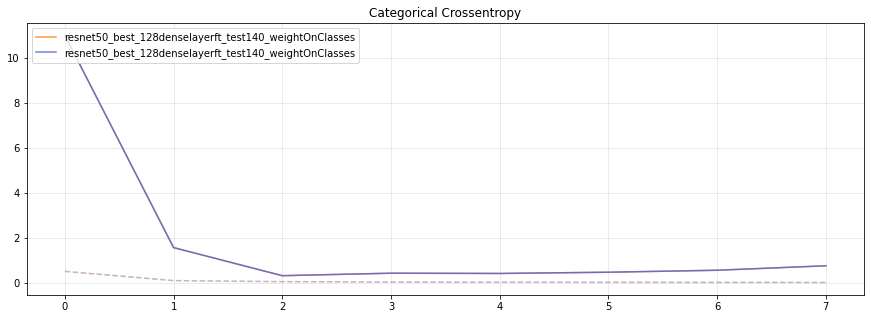

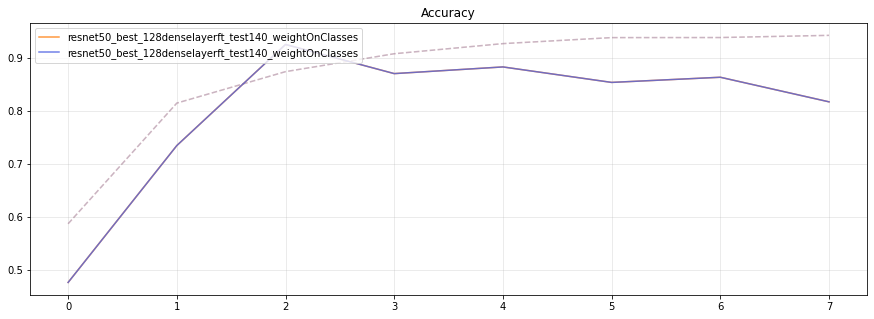

In [55]:
def compareModels(history1, h1lbl, history2=None, h2lbl=''):
  '''
  Plot history1 against history2. 
  If history2 is None then Plot twice history1 (it'll be overlapped)
  h1lbl and h2lbl are the labels of the two histories
  '''
  if history2 == None: 
    history2 = history1
    h2lbl = h1lbl
  # Plot the training
  plt.figure(figsize=(15,5))
  plt.plot(history1['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
  plt.plot(history1['val_loss'], label=h1lbl, alpha=.8, color='#ff7f0e')
  plt.plot(history2['loss'], alpha=.3, color='#4D61E2', linestyle='--')
  plt.plot(history2['val_loss'], label=h2lbl, alpha=.8, color='#4D61E2')
  plt.legend(loc='upper left')
  plt.title('Categorical Crossentropy')
  plt.grid(alpha=.3)

  plt.figure(figsize=(15,5))
  plt.plot(history1['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
  plt.plot(history1['val_accuracy'], label=h1lbl, alpha=.8, color='#ff7f0e')
  plt.plot(history2['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
  plt.plot(history2['val_accuracy'], label=h2lbl, alpha=.8, color='#4D61E2')
  plt.legend(loc='upper left')
  plt.title('Accuracy')
  plt.grid(alpha=.3)

  plt.show()
compareModels(history, model_dir)

In [56]:
# model = tf.keras.models.load_model(os.path.join('./', model_dir))

In [ ]:
# TODO: compute confusion
# from sklearn.metrics import confusion_matrix


# cm = confusion_matrix(
#   np.concatenate([np.argmax(test_gen[i][1], axis=1) for i in range(n_batches)]),    
#   np.argmax(model.predict(test_gen, steps=n_batches), axis=1) 
# )
# print(cm)

In [ ]:
# # Predict the test set with the CNN
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# n_batches = 11

# predictions = model.predict(test_gen, steps=n_batches)
# predictions.shape

# target = np.concatenate([np.argmax(test_gen[i][1], axis=1) for i in range(n_batches)])

# # Compute the confusion matrix
# cm = confusion_matrix(target, np.argmax(predictions, axis=1))
# print(cm)



In [ ]:
# # # Compute the classification metrics
# accuracy = accuracy_score(target, np.argmax(predictions, axis=1))
# precision = precision_score(target, np.argmax(predictions, axis=1), average='macro')
# recall = recall_score(target, np.argmax(predictions, axis=1), average='macro')
# f1 = f1_score(target, np.argmax(predictions, axis=1), average='macro')
# print('Accuracy:',accuracy.round(4))
# print('Precision:',precision.round(4))
# print('Recall:',recall.round(4))
# print('F1:',f1.round(4))

# # Plot the confusion matrix
# plt.figure(figsize=(10,8))
# import seaborn as sns

# sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
# plt.xlabel('True labels')
# plt.ylabel('Predicted labels')
# plt.show()